In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import QUANTAXIS as QA

QUANTAXIS>> start QUANTAXIS
QUANTAXIS>> Welcome to QUANTAXIS, the Version is 1.0.66
QUANTAXIS>>  
 ```````````````````````````````````````````````````````````````````````````````````````````````````````````````````````` 
  ``########`````##````````##``````````##`````````####````````##```##########````````#``````##``````###```##`````######`` 
  `##``````## ```##````````##`````````####````````##`##```````##```````##```````````###``````##````##`````##```##`````##` 
  ##````````##```##````````##````````##`##````````##``##``````##```````##``````````####```````#```##``````##```##``````## 
  ##````````##```##````````##```````##```##```````##```##`````##```````##`````````##`##```````##`##```````##````##``````` 
  ##````````##```##````````##``````##`````##``````##````##````##```````##````````##``###```````###````````##`````##`````` 
  ##````````##```##````````##``````##``````##`````##`````##```##```````##```````##````##```````###````````##``````###```` 
  ##````````##```##````````##`````##`````

# 1. 获取股票, 并选取close 进行初步分析

In [2]:
# 获取上证50中的四根票
code=QA.QA_fetch_stock_block_adv().get_block('上证50').code[0:4]

In [3]:
data=QA.QA_fetch_stock_day_adv(code,'2018-01-01','2018-07-16').to_qfq()

In [4]:

# 选择close序列, 进行pivot成表
close=data.pivot('close')

close.head()

code,600000,600016,600019,600028
date,,,,
2018-01-02,12.587085,7.006029,8.521262,6.008582
2018-01-03,12.527712,7.055368,8.492731,6.102908
2018-01-04,12.527712,7.022475,8.502242,6.508511
2018-01-05,12.557398,7.071814,8.435669,6.659433
2018-01-08,12.547503,7.170490,8.835103,6.650000


## 使用基准价格比较股票

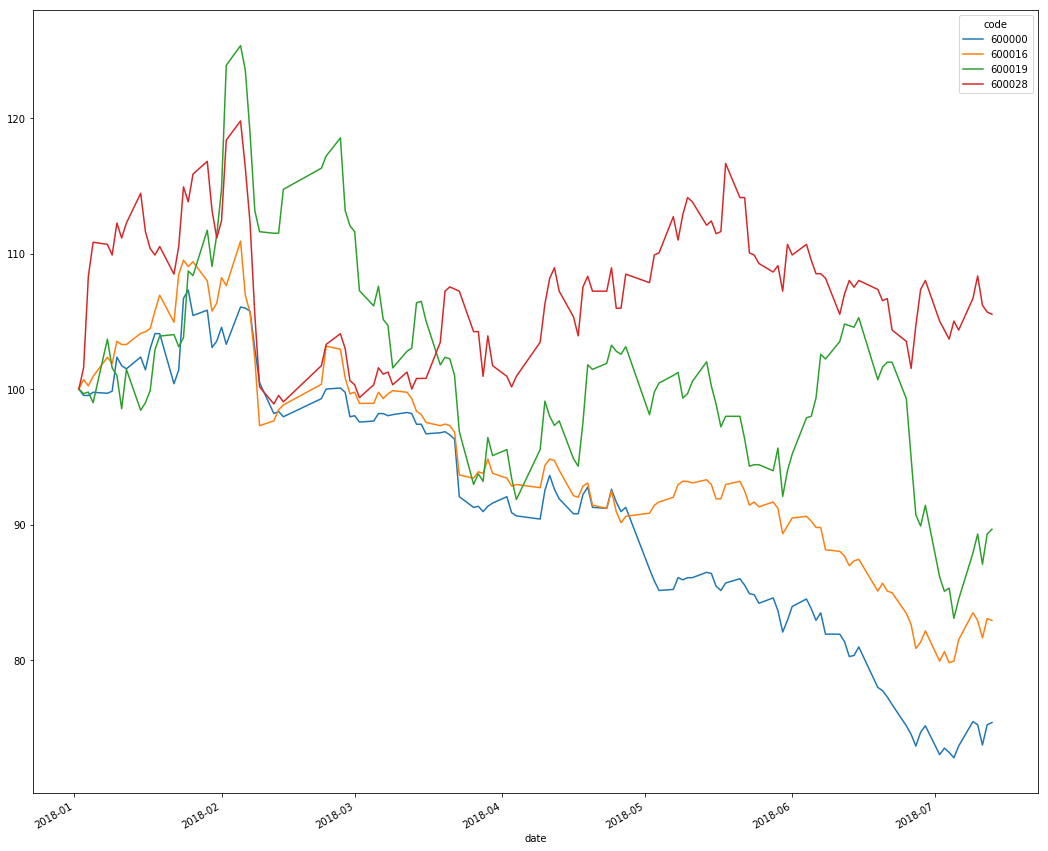

In [5]:
(close/close.iloc[0]*100).plot(figsize = (18,16))

## 计算收益率

In [6]:
log_returns=np.log(close/close.shift(1))
log_returns.head()

code,600000,600016,600019,600028
date,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,-0.004728,0.007018,-0.003354,0.015577
2018-01-04,0.000000,-0.004673,0.001119,0.064345
2018-01-05,0.002367,0.007001,-0.007861,0.022924
2018-01-08,-0.000788,0.013857,0.046264,-0.001417


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002421DDCF860>,
      dtype=object)

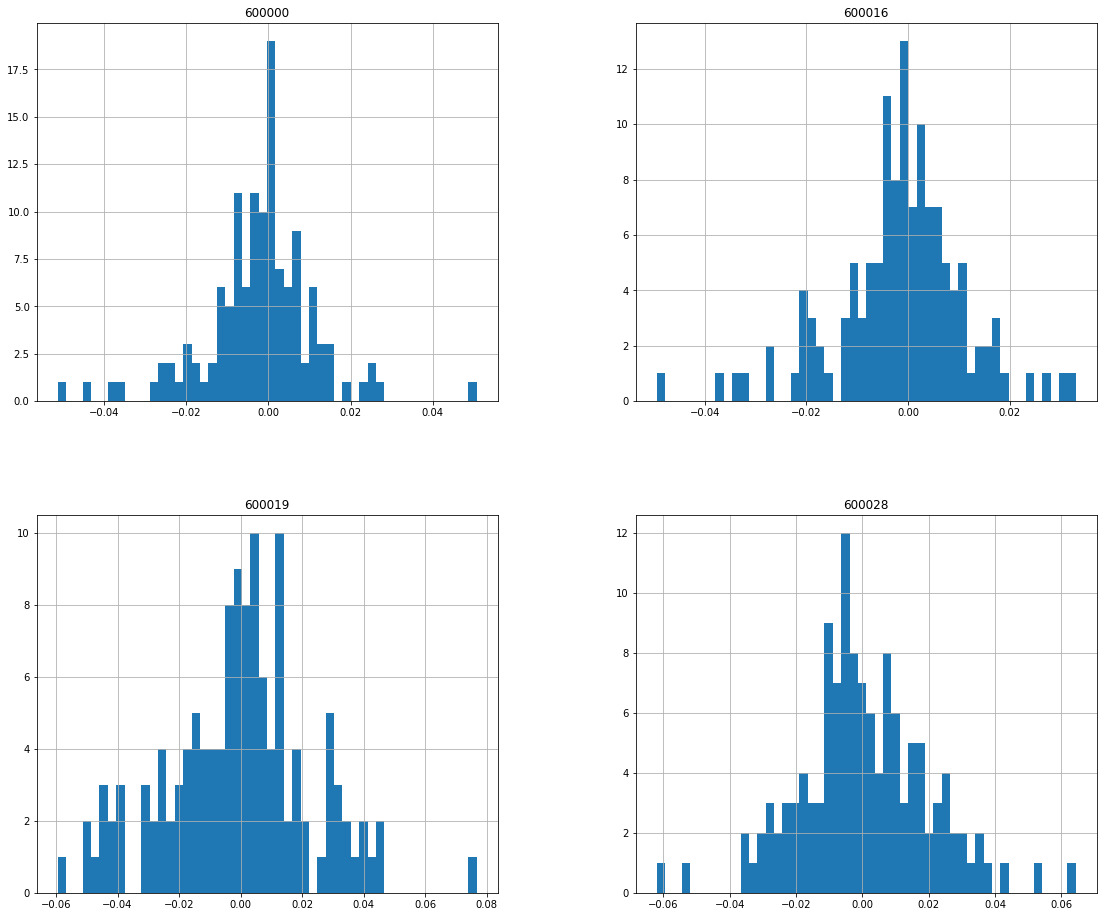

In [7]:
log_returns.hist(bins = 50, figsize = (19,16))

In [8]:
log_returns.cov()*252

code,600000,600016,600019,600028
code,,,,
600000,0.046201,0.030160,0.037957,0.028727
600016,0.030160,0.040633,0.036671,0.032252
600019,0.037957,0.036671,0.135902,0.046658
600028,0.028727,0.032252,0.046658,0.096903


In [9]:
noa=len(code)

## 给不同股票随意分配权重

In [10]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.21942895, 0.14466788, 0.17803594, 0.45786723])

## 计算预期组合年化收益、组合方差和组合标准差

In [11]:
np.sum(log_returns.mean()*weights)*252

-0.16519203884200712

In [12]:
np.dot(weights.T, np.dot(log_returns.cov()*252,weights))

0.05211897463039171

In [13]:
np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()* 252,weights)))

0.2282958051090552

## 用蒙特卡洛模拟产生大量随机组合

进行到此，我们最想知道的是给定的一个股票池（证券组合）如何找到风险和收益平衡的位置。

下面通过一次蒙特卡洛模拟，产生大量随机的权重向量，并记录随机组合的预期收益和方差。

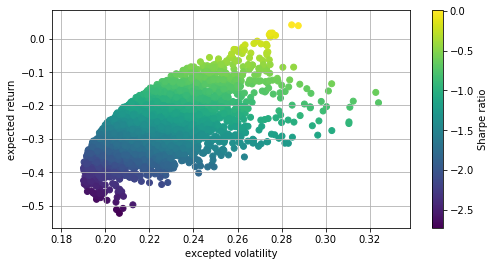

In [24]:
port_returns = []
port_variance = []
for p in range(4000):
    weights = np.random.random(noa)
    weights /=np.sum(weights)
    port_returns.append(np.sum(log_returns.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为4%
risk_free = 0.04
plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

# 投资组合优化1——sharpe最大

建立statistics函数来记录重要的投资组合统计数据（收益，方差和夏普比）

通过对约束最优问题的求解，得到最优解。其中约束是权重总和为1。

In [26]:
def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(log_returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco

#最小化夏普指数的负值
def min_sharpe(weights):
    return -statistics(weights)[2]

#约束是所有参数(权重)的总和为1。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
bnds = tuple((0,1) for x in range(noa))

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
opts

     fun: -0.3395589843140905
     jac: array([1.88688774, 1.29688912, 0.85391124, 0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([7.21644966e-16, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00])


得到的最优组合权重向量为：

In [27]:
opts['x'].round(3)

array([0., 0., 0., 1.])

sharpe最大的组合3个统计数据分别为：

In [28]:
#预期收益率、预期波动率、最优夏普指数
statistics(opts['x']).round(3)

array([0.106, 0.311, 0.34 ])

## 投资组合优化2——方差最小
接下来，我们通过方差最小来选出最优投资组合。

In [30]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
optv

     fun: 0.18986885342564985
     jac: array([0.18988797, 0.18988497, 0.19980709, 0.18966556])
 message: 'Optimization terminated successfully.'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.37442787, 0.54700915, 0.        , 0.07856297])

方差最小的最优组合权重向量及组合的统计数据分别为：

In [19]:
optv['x'].round(3)

array([0.374, 0.547, 0.   , 0.079])

In [31]:
#得到的预期收益率、波动率和夏普指数
statistics(optv['x']).round(3)

array([-0.401,  0.19 , -2.115])

## 组合的有效前沿
有效前沿有既定的目标收益率下方差最小的投资组合构成。

在最优化时采用两个约束，1.给定目标收益率，2.投资组合权重和为1。

In [32]:

def  min_variancemin_varia (weights):
    return statistics(weights)[1]

#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.5,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

下面是最优化结果的展示。

叉号：构成的曲线是有效前沿（目标收益率下最优的投资组合）

红星：sharpe最大的投资组合

黄星：方差最小的投资组合

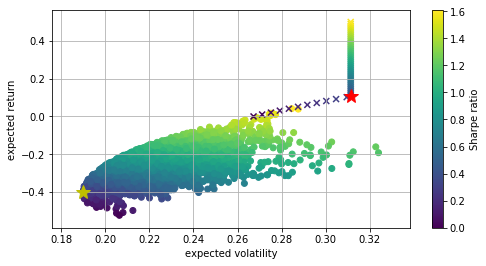

In [33]:
plt.figure(figsize = (8,4))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')